## Các điểm chính:
1. ✅ **Cycle-based segmentation** (1→2→3→4)
2. ✅ **SR=4000Hz, MAX_LEN=3000**
3. ✅ **Butterworth low-pass filter (cutoff=500Hz)**
4. ✅ **Scattering J=6**
5. ✅ **Simpler architecture**: 2 Conv blocks
6. ✅ **2-class classification**: Absent vs Present (loại bỏ Unknown)
7. ✅ **5-fold Cross Validation**

In [ ]:
# 1. Import thư viện
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import preprocessing module
sys.path.append('../src')
from data_preprocessing import HeartSoundPreprocessor

print(f"TensorFlow version: {tf.__version__}")
print("✅ Đã tải tất cả thư viện!")

TensorFlow version: 2.20.0
✅ Đã tải tất cả thư viện!


## 2. Cấu hình tham số

In [2]:
# Đường dẫn
RAW_DATA_DIR = '../data/raw/training_data/'
METADATA_FILE = os.path.join(os.path.dirname(RAW_DATA_DIR.rstrip('/')), 'training_data.csv')
PROCESSED_DATA_DIR = '../data/processed_cnn_method/'
MODEL_PATH = '../results/models/1dcnn_method_best.h5'

# Tham số
SR = 4000  # Sampling rate cao hơn
MAX_LEN = 3000  # Độ dài cycle
J = 6  # Scattering depth
CUTOFF_FREQ = 500  # Butterworth filter cutoff

# Tham số training
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
CV_FOLDS = 5
EARLY_STOPPING_PATIENCE = 5

# Tạo thư mục
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

print(f"📁 Thư mục dữ liệu: {os.path.abspath(RAW_DATA_DIR)}")
print(f"📁 Thư mục xử lý: {os.path.abspath(PROCESSED_DATA_DIR)}")
print(f"\n⚙️ Cấu hình:")
print(f"   - SR = {SR} Hz")
print(f"   - MAX_LEN = {MAX_LEN} samples")
print(f"   - J = {J}")
print(f"   - Cutoff = {CUTOFF_FREQ} Hz")

📁 Thư mục dữ liệu: C:\Users\Admin\Downloads\namCuoi\new_nc\v2\VIP\data\raw\training_data
📁 Thư mục xử lý: C:\Users\Admin\Downloads\namCuoi\new_nc\v2\VIP\data\processed_cnn_method

⚙️ Cấu hình:
   - SR = 4000 Hz
   - MAX_LEN = 3000 samples
   - J = 6
   - Cutoff = 500 Hz


## 3. Khởi tạo Preprocessor

In [ ]:
# Khởi tạo preprocessor với các tham số
preprocessor = HeartSoundPreprocessor(
    sr=SR,
    max_len=MAX_LEN,
    cutoff_freq=CUTOFF_FREQ,
    scattering_j=J
)

print("✅ Đã khởi tạo HeartSoundPreprocessor!")

✅ Đã định nghĩa helper functions!


## 4. Model Architecture

In [4]:
def build_model_cnn(input_shape):
    """
    Model architecture:
    - 2 Conv blocks (128, 64 filters)
    - LeakyReLU + MaxPooling + BatchNorm
    - 3 Dense layers với Dropout
    - 2 output classes (Absent=0, Present=1)
    """
    model = Sequential([
        Input(shape=input_shape),
        
        # Conv Block 1
        Conv1D(128, kernel_size=3, padding='same'),
        LeakyReLU(),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        # Conv Block 2
        Conv1D(64, kernel_size=3, padding='same'),
        LeakyReLU(),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        # Dense layers
        Flatten(),
        Dense(128),
        Dropout(0.3),
        LeakyReLU(),
        
        Dense(64),
        Dropout(0.3),
        LeakyReLU(),
        
        Dense(32),
        ReLU(),
        
        # Output: 2 classes (Absent=0, Present=1)
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✅ Đã định nghĩa model architecture!")

✅ Đã định nghĩa model architecture!


## 4. Load Data và Feature Extraction

In [ ]:
# Xử lý dataset bằng preprocessing module
print("🔄 Bắt đầu xử lý recordings...\n")

X, y = preprocessor.process_dataset(
    raw_data_dir=RAW_DATA_DIR,
    metadata_file=METADATA_FILE,
    use_scattering=True,
    verbose=True
)

✅ Đã tải labels cho 874 bệnh nhân (loại bỏ Unknown)
   - Absent (0): 695
   - Present (1): 179


## 5. Balance Train Set

In [ ]:
# (Optional) Lưu dữ liệu đã xử lý để tái sử dụng
# preprocessor.save_processed_data(X_balanced, y_balanced, PROCESSED_DATA_DIR, prefix='balanced')

# (Optional) Load dữ liệu đã xử lý (nếu đã chạy lần trước)
# X_balanced, y_balanced = preprocessor.load_processed_data(PROCESSED_DATA_DIR, prefix='balanced')

In [ ]:
# Balance dataset bằng preprocessing module
X_balanced, y_balanced = preprocessor.balance_dataset(X, y, random_state=42)

🔄 Bắt đầu xử lý recordings...


Processing:   0%|          | 0/3163 [00:00<?, ?it/s]


✅ Hoàn thành!
   Total samples: 60420
   - Absent (0): 47606 (78.8%)
   - Present (1): 12814 (21.2%)
   Feature shape: (60420, 26, 47)


## 6. Split Train/Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    stratify=y_balanced,
    random_state=42
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Số samples sau balancing: 25628
   - Absent (0): 12814
   - Present (1): 12814


## 7. Training với 5-Fold Cross Validation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    stratify=y_balanced,
    random_state=42
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (20502, 26, 47)
Test set: (5126, 26, 47)


## 8. Final Training & Test

In [9]:
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
fold_acc = []

print("🚀 Bắt đầu Cross Validation...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold}/{CV_FOLDS}")
    print(f"{'='*60}")
    
    # Build model
    model = build_model_cnn(X_train.shape[1:])
    
    # Train
    history = model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=15,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    
    # Evaluate
    _, acc = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)
    fold_acc.append(acc)
    print(f"Validation Accuracy: {acc:.4f}")

print(f"\n{'='*60}")
print("📊 CROSS VALIDATION RESULTS")
print(f"{'='*60}")
print(f"CV Accuracies: {[f'{acc:.4f}' for acc in fold_acc]}")
print(f"Mean: {np.mean(fold_acc):.4f}")
print(f"Std: {np.std(fold_acc):.4f}")
print(f"{'='*60}")

🚀 Bắt đầu Cross Validation...


Fold 1/5
Validation Accuracy: 0.8227

Fold 2/5
Validation Accuracy: 0.8113

Fold 3/5
Validation Accuracy: 0.8149

Fold 4/5
Validation Accuracy: 0.7854

Fold 5/5
Validation Accuracy: 0.8005

📊 CROSS VALIDATION RESULTS
CV Accuracies: ['0.8227', '0.8113', '0.8149', '0.7854', '0.8005']
Mean: 0.8069
Std: 0.0129


## 9. Evaluation

In [10]:
# Build final model
model = build_model_cnn(X_train.shape[1:])

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True
    )
]

print("🚀 Bắt đầu final training...\n")

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training hoàn thành!")

🚀 Bắt đầu final training...

Epoch 1/50
636/641 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6751 - loss: 0.6073

641/641 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7090 - loss: 0.5642 - val_accuracy: 0.7583 - val_loss: 0.5048
Epoch 2/50
636/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7529 - loss: 0.5006

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7544 - loss: 0.4962 - val_accuracy: 0.7815 - val_loss: 0.4504
Epoch 3/50
639/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7749 - loss: 0.4652

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7722 - loss: 0.4673 - val_accuracy: 0.7905 - val_loss: 0.4445
Epoch 4/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7844 - loss: 0.4471

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7839 - loss: 0.4496 - val_accuracy: 0.7977 - val_loss: 0.4273
Epoch 5/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7889 - loss: 0.4387

641/641 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7922 - loss: 0.4357 - val_accuracy: 0.7998 - val_loss: 0.4166
Epoch 6/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7984 - loss: 0.4202 - val_accuracy: 0.7316 - val_loss: 0.5182
Epoch 7/50
638/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8081 - loss: 0.4051

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8064 - loss: 0.4088 - val_accuracy: 0.8117 - val_loss: 0.3990
Epoch 8/50
637/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8078 - loss: 0.4032

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8108 - loss: 0.4007 - val_accuracy: 0.8153 - val_loss: 0.3935
Epoch 9/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8218 - loss: 0.3805

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8182 - loss: 0.3908 - val_accuracy: 0.8182 - val_loss: 0.3897
Epoch 10/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8208 - loss: 0.3822 - val_accuracy: 0.8088 - val_loss: 0.3886
Epoch 11/50
639/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8262 - loss: 0.3679

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8240 - loss: 0.3728 - val_accuracy: 0.8197 - val_loss: 0.3950
Epoch 12/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8307 - loss: 0.3652 - val_accuracy: 0.8184 - val_loss: 0.3976
Epoch 13/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8345 - loss: 0.3605 - val_accuracy: 0.8022 - val_loss: 0.4192
Epoch 14/50
636/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8365 - loss: 0.3534

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8379 - loss: 0.3513 - val_accuracy: 0.8287 - val_loss: 0.3694
Epoch 15/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8437 - loss: 0.3427 - val_accuracy: 0.8061 - val_loss: 0.4051
Epoch 16/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8482 - loss: 0.3348 - val_accuracy: 0.8180 - val_loss: 0.3879
Epoch 17/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8466 - loss: 0.3304 - val_accuracy: 0.8221 - val_loss: 0.3840
Epoch 18/50
640/641 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8521 - loss: 0.3230

641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8518 - loss: 0.3245 - val_accuracy: 0.8340 - val_loss: 0.3690
Epoch 19/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8565 - loss: 0.3188 - val_accuracy: 0.8238 - val_loss: 0.3988
Epoch 20/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8546 - loss: 0.3151 - val_accuracy: 0.8316 - val_loss: 0.3770
Epoch 21/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8597 - loss: 0.3093 - val_accuracy: 0.8328 - val_loss: 0.3869
Epoch 22/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8639 - loss: 0.3018 - val_accuracy: 0.8274 - val_loss: 0.4090
Epoch 23/50
640/641 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8722 - loss: 0.2833

641/641 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8656 - loss: 0.2957 - val_accuracy: 0.8346 - val_loss: 0.3728

✅ Training hoàn thành!


## 10. Training History

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


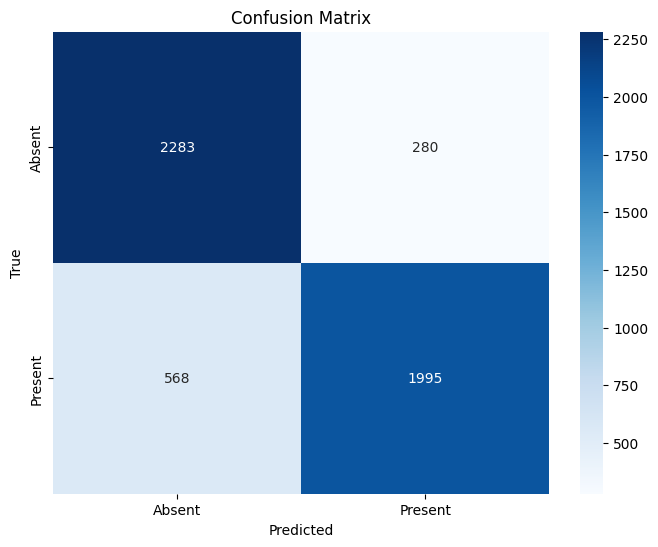


📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Absent       0.80      0.89      0.84      2563
     Present       0.88      0.78      0.82      2563

    accuracy                           0.83      5126
   macro avg       0.84      0.83      0.83      5126
weighted avg       0.84      0.83      0.83      5126


Test Accuracy: 0.8346


In [11]:
# Load best model
from tensorflow.keras.models import load_model
model = load_model(MODEL_PATH)

# Predict
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Absent', 'Present'],
    yticklabels=['Absent', 'Present']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    y_test, y_pred,
    target_names=['Absent', 'Present']
))

# Test Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_acc:.4f}")
print("="*60)

## 12. Training History

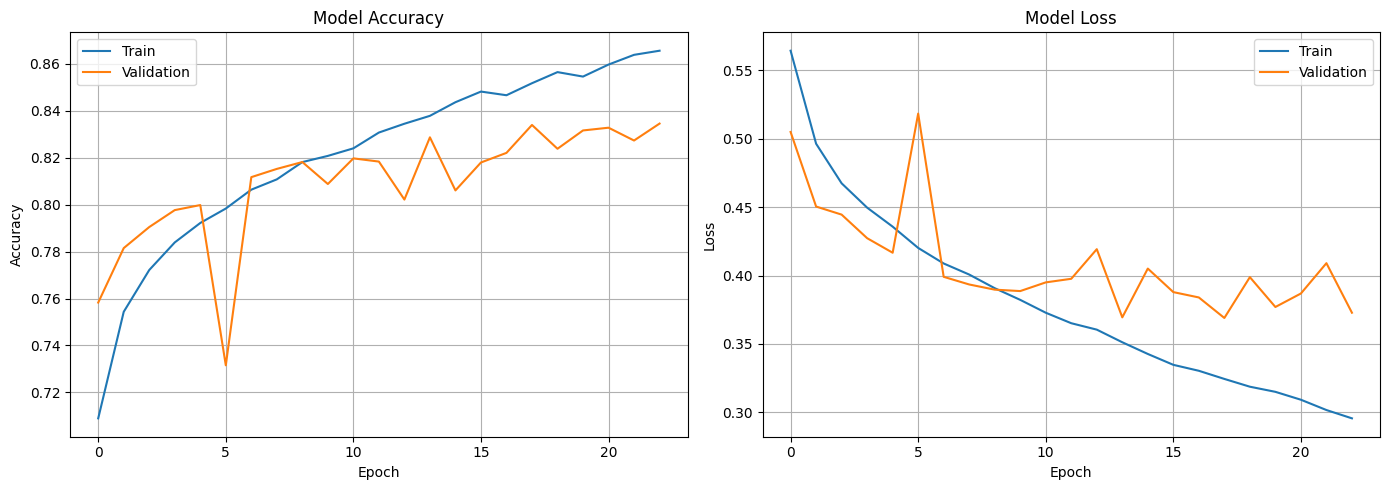

In [12]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()